In [8]:
import random
import pandas as pd
import numpy as np
from copy import deepcopy as cp
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
import torch

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
#mpl.rcParams['text.usetex'] = True

plt.rcParams['font.family'] = "sans-serif" #"Times New Roman" 
#plt.rcParams['fontname'] = 'Calibri'

plt.style.use("seaborn-bright")

In [13]:
from transformers.activations import GELUActivation

In [2]:
#!pip install git+https://github.com/pnnl/DDKS

In [3]:
import ddks

In [9]:
config = AutoConfig.from_pretrained("tiiuae/falcon-7b")

In [10]:
config

FalconConfig {
  "_name_or_path": "tiiuae/falcon-7b",
  "activation": "gelu",
  "alibi": false,
  "apply_residual_connection_post_layernorm": false,
  "architectures": [
    "FalconForCausalLM"
  ],
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoConfig": "tiiuae/falcon-7b--configuration_falcon.FalconConfig",
    "AutoModel": "tiiuae/falcon-7b--modeling_falcon.FalconModel",
    "AutoModelForCausalLM": "tiiuae/falcon-7b--modeling_falcon.FalconForCausalLM",
    "AutoModelForQuestionAnswering": "tiiuae/falcon-7b--modeling_falcon.FalconForQuestionAnswering",
    "AutoModelForSequenceClassification": "tiiuae/falcon-7b--modeling_falcon.FalconForSequenceClassification",
    "AutoModelForTokenClassification": "tiiuae/falcon-7b--modeling_falcon.FalconForTokenClassification"
  },
  "bias": false,
  "bos_token_id": 11,
  "eos_token_id": 11,
  "ffn_hidden_size": 18176,
  "hidden_dropout": 0.0,
  "hidden_size": 4544,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "max_position_e

In [4]:
#model = AutoModelForCausalLM.from_pretrained("facebook/opt-1.3b")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf")
#model = AutoModelForCausalLM.from_pretrained("tiiuae/falcon-7b")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
model.config

LlamaConfig {
  "_name_or_path": "meta-llama/Llama-2-7b-hf",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.43.0.dev0",
  "use_cache": true,
  "vocab_size": 32000
}

In [85]:
model.model.layers[0].mlp.gate_proj

Linear(in_features=4096, out_features=11008, bias=False)

In [87]:
model

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 2048, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 2048)
      (final_layer_norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-23): 24 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
            (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
            (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
            (out_proj): Linear(in_features=2048, out_features=2048, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=2048, out_features=8192, bias=True)
          (fc2): Linear(in_features=8192, out_features=2048, bias=True)
          (final_layer_norm): LayerN

In [7]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head):

In [5]:
model_orig = cp(model)

In [10]:
_, s_orig_first, _ = torch.svd(model.model.decoder.layers[0].fc1.weight)
_, s_orig_last, _ = torch.svd(model.model.decoder.layers[-1].fc1.weight)

s_orig_first = s_orig_first.detach().numpy()
s_orig_last = s_orig_last.detach().numpy()

In [12]:
orig_shapefirst = model.model.decoder.layers[0].fc1.weight.shape[0]
orig_shapelast = model.model.decoder.layers[-1].fc1.weight.shape[0]

In [70]:
sparsities = [0.1, 0.2, 0.3, 0.4, 0.5]

In [71]:
y_layerfirst = []
y_layerlast = []

for sparsity in tqdm(sparsities):
    model = cp(model_orig)
    w = model.model.decoder.layers[0].fc1.weight
    sample = random.sample(range(orig_shapefirst), int((1-sparsity)*orig_shapefirst))
    w = w[sample, :]
    _, s, _ = torch.svd(w)
    s = s.detach().numpy()
    y_layerfirst.append(s)
    
    w2 = model.model.decoder.layers[-1].fc1.weight
    sample = random.sample(range(orig_shapelast), int((1-sparsity)*orig_shapelast))
    w2 = w2[sample, :]
    _, s2, _ = torch.svd(w2)
    s2 = s2.detach().numpy()
    y_layerlast.append(s2)

100%|█████████████████████████████████████████████| 5/5 [00:27<00:00,  5.60s/it]


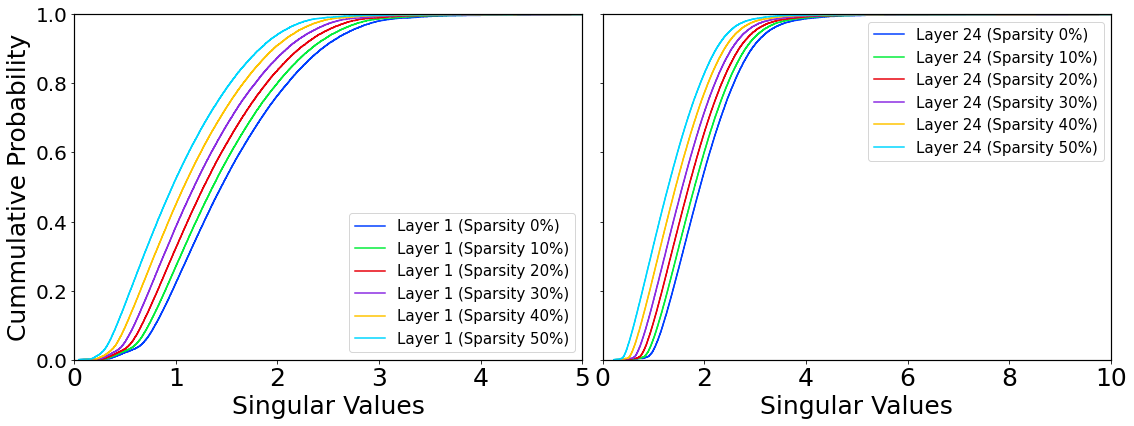

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(18,6), sharey=True)

sns.ecdfplot(x=s_orig_first, label='Layer 1 (Sparsity 0%)', ax=ax[0])
for i, l in enumerate(y_layerfirst):
    sns.ecdfplot(x=l, label='Layer 1 (Sparsity {}%)'.format(int(100*sparsities[i])), ax=ax[0])
    
sns.ecdfplot(x=s_orig_last, label='Layer 24 (Sparsity 0%)', ax=ax[1])
for i, l in enumerate(y_layerlast):
    sns.ecdfplot(x=l, label='Layer 24 (Sparsity {}%)'.format(int(100*sparsities[i])), ax=ax[1])

ax[0].set_xlabel('Singular Values', fontsize=25)
ax[1].set_xlabel('Singular Values', fontsize=25)
ax[0].set_ylabel('Cummulative Probability', fontsize=25)

ax[0].xaxis.set_tick_params(labelsize=25)
ax[1].xaxis.set_tick_params(labelsize=25)

ax[0].yaxis.set_tick_params(labelsize=20)

ax[0].set_xlim(0,5)
ax[1].set_xlim(0,10)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.04, 
                    hspace=0.2)

plt.rc('legend', fontsize=15)
ax[0].legend()
ax[1].legend()

plt.show()

In [38]:
calculation = ddks.methods.ddKS()

In [73]:
num_trials = 50

In [74]:
y_layerfirst2 = []
y_layerlast2 = []

for sparsity in tqdm(sparsities):
    l1 = []
    l2 = []
    
    for trial in tqdm(range(num_trials)):
        model = cp(model_orig)
        w = model.model.decoder.layers[0].fc1.weight
        sample = random.sample(range(orig_shapefirst), int((1-sparsity)*orig_shapefirst))
        w = w[sample, :]
        _, s, _ = torch.svd(w)
        
        l1.append(calculation(torch.tensor(s_orig_first).unsqueeze(1), s.unsqueeze(1)).item())

        w2 = model.model.decoder.layers[-1].fc1.weight
        sample = random.sample(range(orig_shapelast), int((1-sparsity)*orig_shapelast))
        w2 = w2[sample, :]
        _, s2, _ = torch.svd(w2)
        
        l2.append(calculation(torch.tensor(s_orig_last).unsqueeze(1), s2.unsqueeze(1)).item())
    
    y_layerfirst2.append(l1)
    y_layerlast2.append(l2)

 86%|████████████████████████████████████▉      | 43/50 [03:08<00:28,  4.05s/it]


 72%|██████████████████████████████▉            | 36/50 [02:15<00:51,  3.70s/it]


100%|████████████████████████████████████████████| 5/5 [16:58<00:00, 203.79s/it]


In [75]:
df1 = []
df2 = []

for i, l in enumerate(y_layerfirst2):
    df_ = pd.DataFrame()
    df_['KS Distance'] = l
    df_['Layer'] = '{}%'.format(int(100*sparsities[i]))
    df1.append(df_)
    
df1 = pd.concat(df1, axis=0)
#df1['KS Distance'] = df1['KS Distance'] * 100

for i, l in enumerate(y_layerlast2):
    df_ = pd.DataFrame()
    df_['KS Distance'] = l
    df_['Layer'] = '{}%'.format(int(100*sparsities[i]))
    df2.append(df_)
    
df2 = pd.concat(df2, axis=0)
#df2['KS Distance'] = df2['KS Distance'] * 100

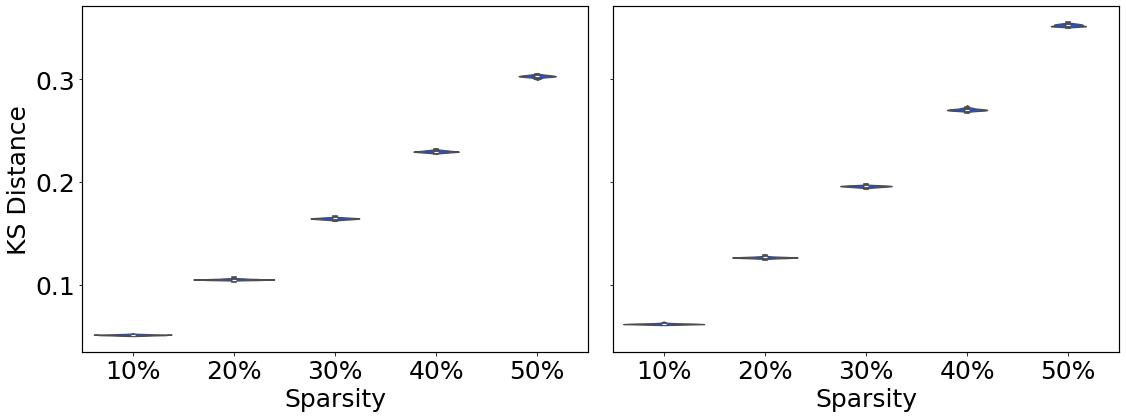

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(18,6), sharey=True)

sns.violinplot(df1, x='Layer',y='KS Distance', ax=ax[0])
sns.violinplot(df2, x='Layer',y='KS Distance', ax=ax[1])

ax[0].set_xlabel('Sparsity', fontsize=25)
ax[1].set_xlabel('Sparsity', fontsize=25)

ax[0].set_ylabel('KS Distance', fontsize=25)
#ax[1].set_ylabel('KS Distance', fontsize=25)

ax[0].xaxis.set_tick_params(labelsize=25)
ax[1].xaxis.set_tick_params(labelsize=25)

ax[0].yaxis.set_tick_params(labelsize=25)
#ax[1].yaxis.set_tick_params(labelsize=25)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.05, 
                    hspace=0.2)

plt.show()